In [1]:
import pycaret
import pandas as pd

In [2]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [3]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [4]:
data.tail()

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature
timestamp,,,,,
2025-02-07 07:00:00,70.933952,34.743259,29.321219,26.166471,28.271927
2025-02-08 07:00:00,69.348548,30.654249,26.000000,22.380675,28.385596
2025-02-09 07:00:00,69.916384,28.971065,24.616898,20.976852,28.373742
2025-02-10 07:00:00,71.226336,30.652667,25.856981,22.374574,28.251201
2025-02-11 07:00:00,68.159624,32.532955,27.522727,24.120455,28.693799


In [5]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [6]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [7]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [8]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [9]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [10]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [11]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [12]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [13]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [14]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

rolling_size = 7
for i in range(2,rolling_size+1):
    data[f'pm_2_5_rolling_{i}'] = data['pm_2_5'].rolling(window=i).mean().shift(1)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'pm_2_5_lag_{i}'] = data['pm_2_5'].shift(i)

data['humidity_rolling_2'] = data['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data['humidity_rolling_5'] = data['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data['humidity_rolling_7'] = data['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_7'] = data['humidity'].shift(7)

data['temperature_rolling_2'] = data['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data['temperature_rolling_5'] = data['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data['temperature_rolling_7'] = data['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_7'] = data['temperature'].shift(7)

In [15]:
# data["temp_diff"] = data["temperature"].diff()
# data["humidity_diff"] = data["humidity"].diff()

In [16]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_rolling_2', 'pm_2_5_rolling_3', 'pm_2_5_rolling_4',
       'pm_2_5_rolling_5', 'pm_2_5_rolling_6', 'pm_2_5_rolling_7',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'humidity_rolling_2',
       'humidity_rolling_5', 'humidity_rolling_7', 'humidity_lag_1',
       'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_7',
       'temperature_rolling_2', 'temperature_rolling_5',
       'temperature_rolling_7', 'temperature_lag_1', 'temperature_lag_2',
       'temperature_lag_3', 'temperature_lag_7'],
      dtype='object')

In [17]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

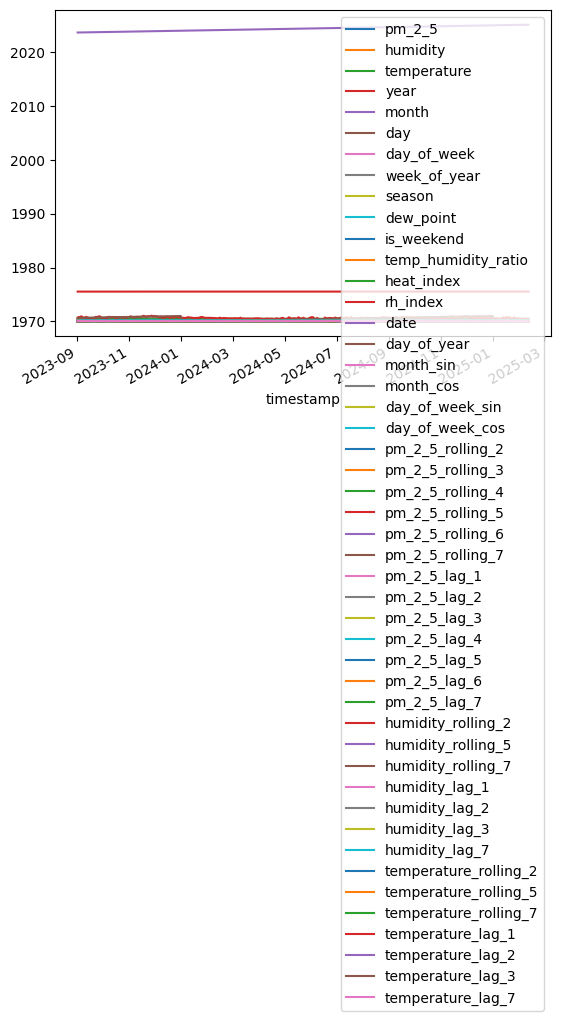

In [18]:
data_filtered.plot()

In [19]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [20]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [21]:
train_data.shape

(500, 47)

In [22]:
test_data.shape

(30, 47)

In [23]:
test_data.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_rolling_2,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,42.594631,78.292202,25.997341,2025,1,13,0,3,2,21.655782,...,73.568381,70.491487,72.844643,26.896216,28.008569,28.287636,25.434972,28.357459,28.945704,28.825509


In [24]:
test_data.tail(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_rolling_2,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,69.916384,69.348548,70.266522,28.312472,28.372328,28.280646,28.251201,28.373742,28.385596,27.775432


In [25]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_rolling_2,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,71.500943,70.266522,68.520368,28.453313,28.202099,27.951803,28.579177,28.327450,27.775432,27.336718
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,69.511783,71.500943,69.231031,28.425552,28.319706,28.085404,28.271927,28.579177,28.327450,27.315410
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,70.933952,69.511783,70.341639,28.328761,28.267916,28.238288,28.385596,28.271927,28.579177,27.683890
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,69.348548,70.933952,65.114261,28.379669,28.387578,28.336838,28.373742,28.385596,28.271927,28.644544
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,69.916384,69.348548,70.266522,28.312472,28.372328,28.280646,28.251201,28.373742,28.385596,27.775432


In [26]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_rolling_2', 'pm_2_5_rolling_3', 'pm_2_5_rolling_4',
       'pm_2_5_rolling_5', 'pm_2_5_rolling_6', 'pm_2_5_rolling_7',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'humidity_rolling_2',
       'humidity_rolling_5', 'humidity_rolling_7', 'humidity_lag_1',
       'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_7',
       'temperature_rolling_2', 'temperature_rolling_5',
       'temperature_rolling_7', 'temperature_lag_1', 'temperature_lag_2',
       'temperature_lag_3', 'temperature_lag_7'],
      dtype='object')

In [27]:
# train_data.dropna()

In [28]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(500, 47)"
4,Transformed data shape,"(482, 49)"
5,Transformed train set shape,"(332, 49)"
6,Transformed test set shape,"(150, 49)"
7,Numeric features,45
8,Date features,1
9,Preprocess,True


In [30]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,5.1200,44.1443,6.4939,0.5278,0.3442,0.3257,0.1017
lasso,Lasso Regression,5.1165,44.1497,6.4926,0.5277,0.3444,0.3255,0.1300
en,Elastic Net,5.1605,44.7436,6.5389,0.5203,0.3478,0.3282,0.1050
br,Bayesian Ridge,5.1876,44.9907,6.5598,0.5189,0.3487,0.3307,0.0800
omp,Orthogonal Matching Pursuit,5.1398,44.9781,6.5605,0.5178,0.3461,0.3283,0.1025
huber,Huber Regressor,5.0845,45.6962,6.5707,0.5113,0.3447,0.3069,0.1350
gbr,Gradient Boosting Regressor,5.3462,46.9290,6.7231,0.4977,0.3554,0.3448,0.2558
ada,AdaBoost Regressor,5.5100,47.5578,6.7657,0.4966,0.3710,0.3813,0.1908
et,Extra Trees Regressor,5.3148,46.9296,6.7028,0.4962,0.3605,0.3519,0.3042
rf,Random Forest Regressor,5.3562,47.1286,6.7453,0.4960,0.3622,0.3557,0.3758


In [31]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4418,30.8152,5.5511,0.6611,0.3278,0.3086
1,7.4588,105.1100,10.2523,0.4209,0.4265,0.3659
2,4.7770,29.8153,5.4603,0.5926,0.4165,0.4826
3,6.4266,61.6108,7.8493,0.4516,0.4296,0.4604
4,4.6346,48.8369,6.9883,0.5303,0.2912,0.2307
5,5.3565,43.2313,6.5751,0.2794,0.3975,0.4178
6,5.8057,48.3112,6.9506,0.2107,0.4098,0.4407
7,6.0066,52.6544,7.2563,0.5856,0.3998,0.4208
8,4.6336,30.7702,5.5471,0.6032,0.2920,0.2818


In [ ]:
exp1.evaluate_model(model_1)

In [33]:
model_2 = exp1.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.8485,33.1800,5.7602,0.6351,0.3277,0.3222
1,7.3318,103.2075,10.1591,0.4314,0.4084,0.3417
2,3.9226,22.2212,4.7139,0.6964,0.3381,0.3593
3,5.5188,43.8653,6.6231,0.6095,0.3613,0.3751
4,5.2661,63.4735,7.9670,0.3895,0.3199,0.2496
5,5.2633,40.8689,6.3929,0.3188,0.3806,0.3943
6,5.5254,49.3660,7.0261,0.1935,0.4001,0.4160
7,5.8284,46.3497,6.8081,0.6352,0.3770,0.3902
8,4.8520,31.0512,5.5724,0.5996,0.2897,0.2888


In [ ]:
model_3 = exp1.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.3498,41.1805,6.4172,0.5471,0.3692,0.3698
1,7.9688,113.1429,10.6369,0.3767,0.4418,0.3761
2,4.1071,22.4421,4.7373,0.6933,0.3472,0.3721
3,6.5490,64.7876,8.0491,0.4233,0.4306,0.4435
4,4.9621,56.6840,7.5289,0.4548,0.2955,0.2316
5,4.9588,38.5733,6.2107,0.3570,0.3709,0.3767
6,6.0048,49.2798,7.0200,0.1949,0.4136,0.4520
7,5.3887,43.4339,6.5904,0.6582,0.3676,0.3777
8,4.5566,30.6665,5.5377,0.6046,0.2980,0.2751


In [ ]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_1, data=new_data)
predictions.head()

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,is_weekend,...,humidity_lag_3,humidity_lag_7,temperature_rolling_2,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,78.292206,25.997341,2025,1,13,0,3,2,21.655781,0,...,70.491486,72.844643,26.896215,28.008570,28.287636,25.434973,28.357460,28.945705,28.825508,29.927804
2025-01-14 07:00:00,74.887207,26.780884,2025,1,14,1,3,2,21.758324,0,...,73.568382,70.630295,25.716156,27.423729,27.883612,25.997341,25.434973,28.357460,29.145098,35.394236
2025-01-15 07:00:00,74.201401,27.146723,2025,1,15,2,3,2,21.987003,0,...,85.379807,71.168640,26.389112,27.103271,27.545866,26.780884,25.997341,25.434973,28.921543,35.700378
2025-01-16 07:00:00,89.873428,24.990604,2025,1,16,3,3,2,22.965288,0,...,78.292206,70.983574,26.963802,26.743475,27.292320,27.146723,26.780884,25.997341,28.383165,34.728874
2025-01-17 07:00:00,80.848938,27.221664,2025,1,17,4,3,2,23.391453,0,...,74.887207,70.491486,26.068663,26.070105,26.807669,24.990604,27.146723,26.780884,28.945705,35.791569


In [ ]:
predict_v = predictions['prediction_label']
# predict_v.head(7)

In [ ]:
real = test_data['pm_2_5']
# real.head(7)

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

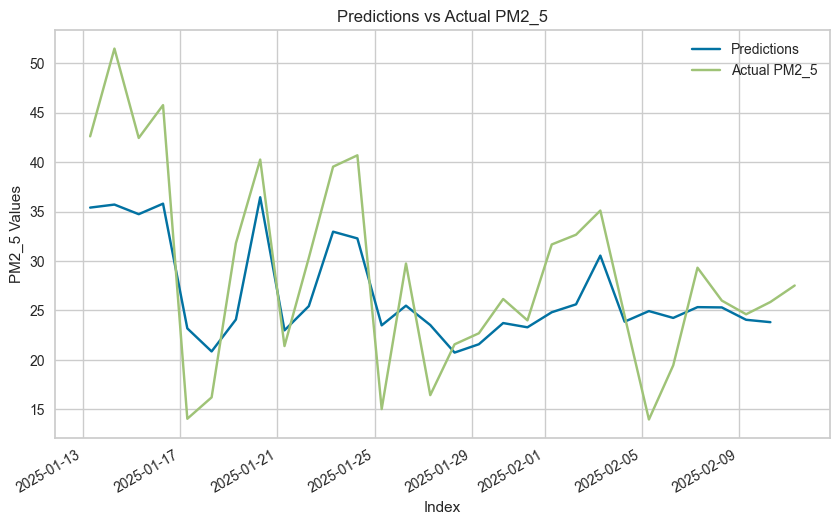

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [ ]:
# model_1 = exp1.create_model('rf')
# tune_1 = exp1.tune_model(model_1)

In [37]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_2

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered

    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    for i in range(2,rolling_size+1):
        data_compare[f'pm_2_5_rolling_{i}'] = data_compare['pm_2_5'].rolling(window=i).mean().shift(1)

    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

        # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

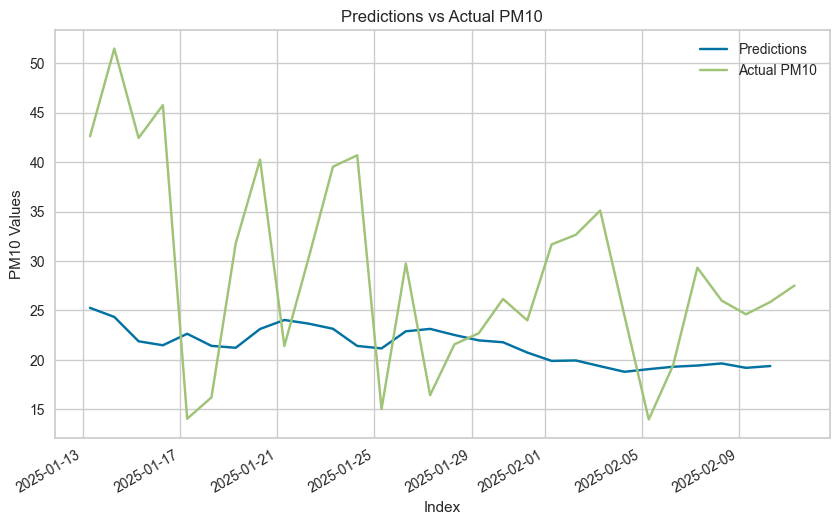

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM10')
plt.xlabel('Index')
plt.ylabel('PM10 Values')

# แสดงกราฟ
plt.show()

In [39]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = real_data["pm_2_5"][:"2025-2-10"]
y_pred = result['prediction_label'].shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: -0.4587
Mean Absolute Error (MAE): 9.7850
Root Mean Squared Error (RMSE): 12.0570
Accuracy: 66.03%


In [ ]:
# ค่า R² และ MAPE
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE in percentage

# การปรับสเกลของ R² (สมมติให้อยู่ในช่วง 0-100 เพื่อให้อยู่ในช่วงเดียวกับ MAPE)
r2_scaled = r2 * 100  # เปลี่ยน R² ให้เป็นค่าร้อยละ

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



R² Score: 0.4020
Mean Absolute Percentage Error (MAPE): 23.85%
